In [1]:
import os, cv2
import matplotlib.pyplot as plt
import zipfile, gdown
import kagglehub
import shutil

/Users/zepyoorkhechadoorian/Documents/projects/mri-brain-tumor/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# skip this cell if dataset is already downloaded
if os.path.exists("../data/brain_tumor_dataset"):

    print("Dataset already exists. Skipping download.")

else:

    # Download latest version to kaggle cache
    path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

    print("Path to dataset files:", path)

    # Create data directory if it doesn't exist
    data_dir = "../data/"
    os.makedirs(data_dir, exist_ok=True)

    # Copy the downloaded dataset to data directory
    destination = os.path.join(data_dir, "brain_tumor_dataset")
    if os.path.exists(destination):
        shutil.rmtree(destination)  # Remove if already exists
    shutil.copytree(path, destination)

    print(f"Dataset copied to: {destination}")

Dataset already exists. Skipping download.


In [6]:
# Explore the downloaded dataset structure
dataset_path = "../data/brain_tumor_dataset"
print("Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files in each directory
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

Dataset structure:
brain_tumor_dataset/
  Training/
    no_tumor/
      image(115).jpg
      image(142).jpg
      image(49).jpg
      image(1).jpg
      image(284).jpg
      ... and 390 more files
    meningioma_tumor/
      m1(69).jpg
      m3 (126).jpg
      m3 (62).jpg
      m2 (62).jpg
      m1(86).jpg
      ... and 817 more files
    glioma_tumor/
      gg (362).jpg
      gg (698).jpg
      gg (732).jpg
      gg (227).jpg
      gg (677).jpg
      ... and 821 more files
    pituitary_tumor/
      p (477).jpg
      p (162).jpg
      p (498).jpg
      p (532).jpg
      p (75).jpg
      ... and 822 more files
  Testing/
    no_tumor/
      image(49).jpg
      image(1).jpg
      image(103).jpg
      image(73).jpg
      image(24).jpg
      ... and 100 more files
    meningioma_tumor/
      image(49).jpg
      image(1).jpg
      image(73).jpg
      image(24).jpg
      image(32).jpg
      ... and 110 more files
    glioma_tumor/
      image(49).jpg
      image(1).jpg
      image(73).jpg
 

Classes found: ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']


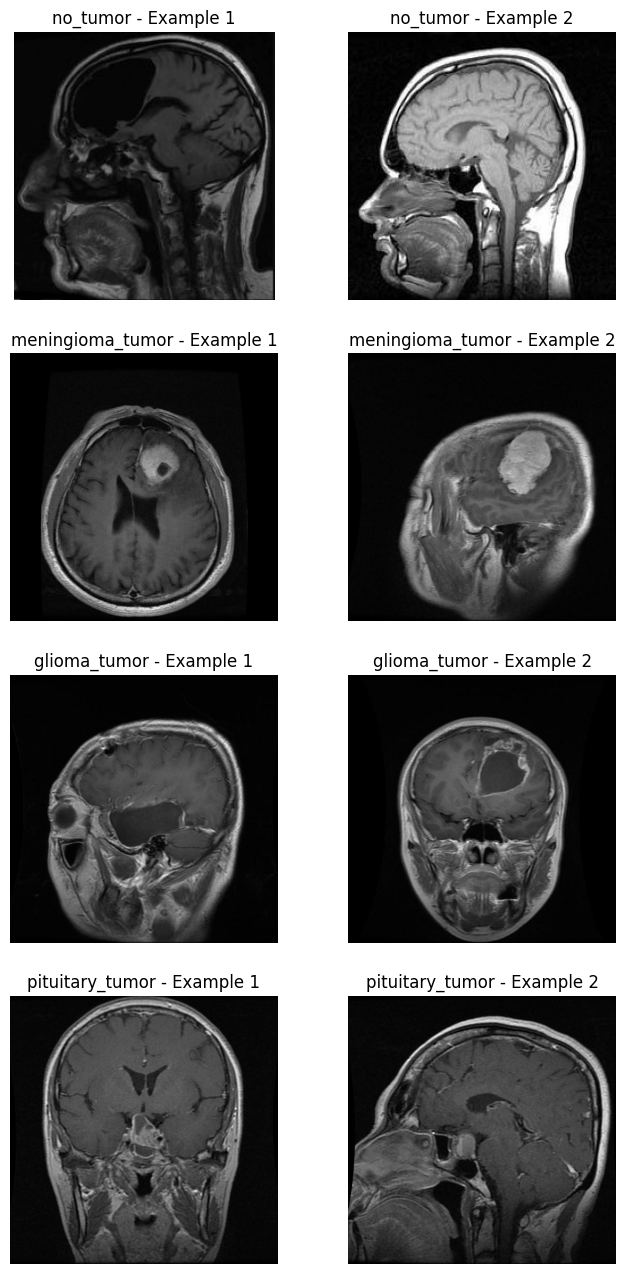

In [7]:
# print two examples from each class

# get classes by listing directories in the dataset path
training_path = "../data/brain_tumor_dataset/Training"
classes = [d for d in os.listdir(training_path) if os.path.isdir(os.path.join(training_path, d))]
print("Classes found:", classes)

fig, axes = plt.subplots(len(classes), 2, figsize=(8, 4 * len(classes)))
for i, cls in enumerate(classes):
    class_dir = os.path.join(training_path, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    for j in range(2):
        img_path = os.path.join(class_dir, images[j])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{cls} - Example {j+1}")
        axes[i, j].axis('off')

Dataset Statistics:
Dataset           Testing  Training
Class                              
glioma_tumor          100       826
meningioma_tumor      115       822
no_tumor              105       395
pituitary_tumor        74       827


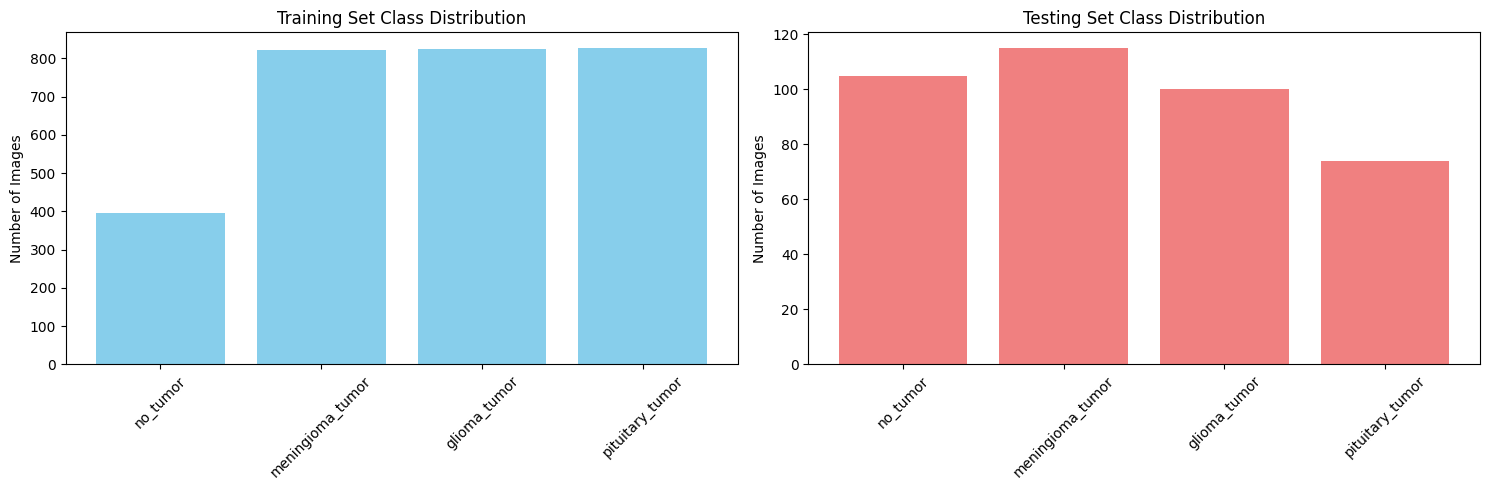

In [ ]:
# 1. Dataset Statistics and Class Distribution
import numpy as np
import pandas as pd
from collections import Counter

# Collect dataset statistics
stats = []
for dataset_type in ["Training", "Testing"]:
    dataset_path = os.path.join("../data/brain_tumor_dataset", dataset_type)
    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        stats.append({'Dataset': dataset_type, 'Class': cls, 'Count': num_images})

df_stats = pd.DataFrame(stats) # Create DataFrame from stats
print("Dataset Statistics:")
print(df_stats.pivot(index='Class', columns='Dataset', values='Count'))

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
train_counts = df_stats[df_stats['Dataset'] == 'Training']
ax1.bar(train_counts['Class'], train_counts['Count'], color='skyblue')
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Testing set distribution
test_counts = df_stats[df_stats['Dataset'] == 'Testing']
ax2.bar(test_counts['Class'], test_counts['Count'], color='lightcoral')
ax2.set_title('Testing Set Class Distribution')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Image Dimension Statistics:
Height - Min: 200, Max: 1322, Mean: 435.4
Width - Min: 200, Max: 1358, Mean: 434.3
Channels - Min: 3, Max: 3, Mean: 3.0
Unique dimensions: 39


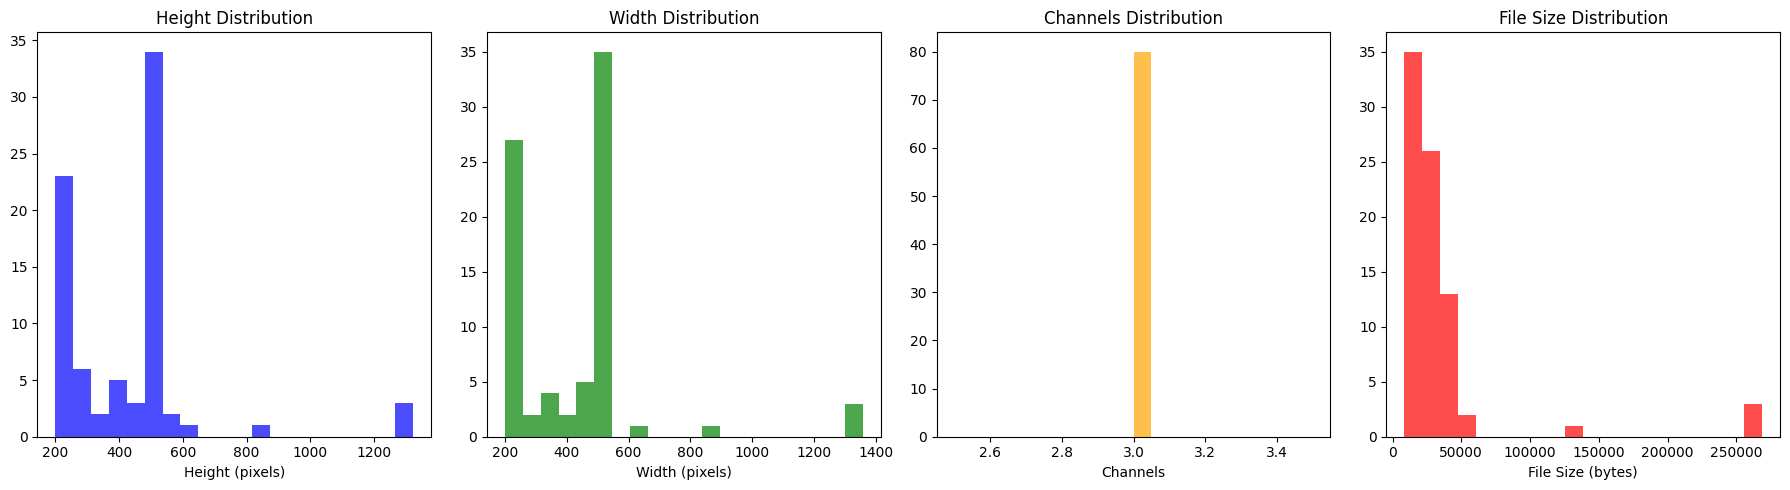

In [24]:
# Image Size Analysis
def analyze_image_dimensions():
    """Analyze and visualize image dimensions in the dataset.
    Inputs:         None (uses predefined dataset path)
    Outputs:        DataFrame with image dimensions statistics (Height, Width, Channels)
    """
    dimensions = []
    file_sizes = []
    
    for dataset_type in ["Training", "Testing"]:
        dataset_path = os.path.join("../data/brain_tumor_dataset", dataset_type)
        for cls in classes:
            class_dir = os.path.join(dataset_path, cls)
            images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Sample 10 images per class to avoid loading too many
            sample_images = images[:10] if len(images) > 10 else images
            
            for img_name in sample_images:
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    h, w, c = img.shape # height, width, channels
                    dimensions.append({'Dataset': dataset_type, 'Class': cls, 'Height': h, 'Width': w, 'Channels': c})
                    file_sizes.append(os.path.getsize(img_path))
    
    df_dims = pd.DataFrame(dimensions)
    
    print("Image Dimension Statistics:")
    print(f"Height - Min: {df_dims['Height'].min()}, Max: {df_dims['Height'].max()}, Mean: {df_dims['Height'].mean():.1f}")
    print(f"Width - Min: {df_dims['Width'].min()}, Max: {df_dims['Width'].max()}, Mean: {df_dims['Width'].mean():.1f}")
    print(f"Channels - Min: {df_dims['Channels'].min()}, Max: {df_dims['Channels'].max()}, Mean: {df_dims['Channels'].mean():.1f}")
    print(f"Unique dimensions: {df_dims[['Height', 'Width']].drop_duplicates().shape[0]}")
    
    # Plot dimension distribution
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    
    axes[0].hist(df_dims['Height'], bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Height Distribution')
    axes[0].set_xlabel('Height (pixels)')
    
    axes[1].hist(df_dims['Width'], bins=20, alpha=0.7, color='green')
    axes[1].set_title('Width Distribution')
    axes[1].set_xlabel('Width (pixels)')

    axes[2].hist(df_dims['Channels'], bins=20, alpha=0.7, color='orange')
    axes[2].set_title('Channels Distribution')
    axes[2].set_xlabel('Channels')
    
    axes[3].hist(file_sizes, bins=20, alpha=0.7, color='red')
    axes[3].set_title('File Size Distribution')
    axes[3].set_xlabel('File Size (bytes)')
    
    plt.tight_layout()
    plt.show()
    
    return df_dims

df_dimensions = analyze_image_dimensions()

In [ ]:
# Summary Statistics
print("=== DATASET SUMMARY ===")
print(f"Total classes: {len(classes)}")
print(f"Class names: {classes}")

total_train = df_stats[df_stats['Dataset'] == 'Training']['Count'].sum()
total_test = df_stats[df_stats['Dataset'] == 'Testing']['Count'].sum()
print(f"Total training images: {total_train}")
print(f"Total testing images: {total_test}")
print(f"Total images: {total_train + total_test}")

print("\n=== CLASS BALANCE ===")
train_balance = df_stats[df_stats['Dataset'] == 'Training']
for _, row in train_balance.iterrows():
    percentage = (row['Count'] / total_train) * 100
    print(f"{row['Class']}: {row['Count']} images ({percentage:.1f}%)")

print(f"\n=== IMAGE PROPERTIES ===")
if 'df_dimensions' in locals():
    print(f"Common image size: {df_dimensions['Height'].mode().iloc[0]}x{df_dimensions['Width'].mode().iloc[0]}")
    print(f"Size variation: Height ({df_dimensions['Height'].min()}-{df_dimensions['Height'].max()}), Width ({df_dimensions['Width'].min()}-{df_dimensions['Width'].max()})")

if 'df_quality' in locals().keys():
    print(f"\n=== QUALITY METRICS ===")
    print(f"Average sharpness: {df_quality['sharpness'].mean():.2f}")
    print(f"Average contrast: {df_quality['contrast'].mean():.2f}")
    print(f"Average brightness: {df_quality['brightness'].mean():.2f}")

=== DATASET SUMMARY ===
Total classes: 4
Class names: ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']
Total training images: 2870
Total testing images: 394
Total images: 3264

=== CLASS BALANCE ===
no_tumor: 395 images (13.8%)
meningioma_tumor: 822 images (28.6%)
glioma_tumor: 826 images (28.8%)
pituitary_tumor: 827 images (28.8%)
__name__
__doc__
__package__
__loader__
__spec__
__builtin__
__builtins__
_ih
_oh
_dh
In
Out
get_ipython
exit
quit
open
_
__
___
__vsc_ipynb_file__
_i
_ii
_iii
_i1
os
cv2
plt
zipfile
gdown
kagglehub
shutil
_i2
_i3
dataset_path
root
dirs
files
level
indent
subindent
file
_i4
training_path
classes
fig
axes
i
cls
class_dir
images
j
img_path
img
_i5
dataset_type
num_images
_i6
_i7
_i8
_i9
np
_i10
pd
Counter
stats
df_stats
ax1
ax2
train_counts
test_counts
_i11
analyze_image_dimensions
df_dimensions
_i12
total_train
total_test
train_balance
row
percentage
_i13
_i14
_i15
_i16
_i17
each
_i18
_i19
_i20

=== IMAGE PROPERTIES ===
Common image size: 5